In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.bencmark = True
plt.ion()

# Load Data

In [5]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip -P data && cd data && unzip hymenoptera_data.zip

--2025-02-25 20:44:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:2549:7800:d:607e:4540:93a1, 2600:9000:2549:3400:d:607e:4540:93a1, 2600:9000:2549:f800:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:2549:7800:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘data/hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  11.0MB/s    in 11s     

2025-02-25 20:45:00 (4.21 MB/s) - ‘data/hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inf

In [9]:
# Determine the device to be used for computation (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define data transformation pipelines for training and validation datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # Randomly crop the image to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # Resize the image to 256x256 pixels
        transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert the image to a Tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet means and stds
    ])
}

# Set the data directory containing the training and validation datasets
data_dir = 'data/hymenoptera_data'

# Create datasets for training and validation, applying the respective data transformations
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}

# Create DataLoaders for training and validation datasets for batching and shuffling
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x],  # Dataset to load
        batch_size=4,       # Number of samples per batch
        shuffle=True,       # Shuffle data at every epoch
        num_workers=(os.cpu_count() if device.type == 'cpu' else min(os.cpu_count(), 4))  # Number of workers for data loading
    ) for x in ['train', 'val']
}

# Calculate the size of each dataset (number of samples)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Get the class names from the training dataset
class_names = image_datasets['train'].classes

print(f'Using {device} device')  # Output the chosen device

Using cpu device


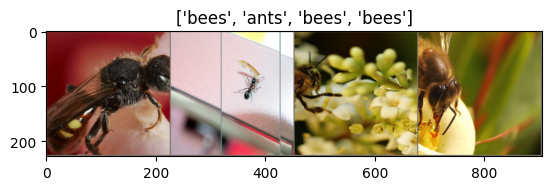

In [7]:
# Define a function to display an image from a Tensor
def imshow(inp, title=None):
    """Display image for Tensor."""
    # Convert the input Tensor to a NumPy array and transpose it for visualization
    inp = inp.numpy().transpose((1, 2, 0))

    # Define the mean and standard deviation used for normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Denormalize the image by reversing the normalization
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # Clip values to ensure they're within the valid range [0, 1]

    # Display the image using matplotlib
    plt.imshow(inp)
    if title is not None:
        plt.title(title)  # Set the title for the image if provided
    plt.pause(0.001)  # Pause a bit to ensure the plots are updated

# Get a batch of training data from the DataLoader
inputs, classes = next(iter(dataloaders['train']))

# Create a grid of images from the batch for visualization
out = torchvision.utils.make_grid(inputs)

# Display the grid of images along with their class names
imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()  # Record the start time of training

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        # Define the path for saving the model parameters
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)  # Save initial model state
        best_acc = 0.0  # Initialize the best accuracy to zero

        # Loop over each epoch
        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')  # Print current epoch
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluation mode

                running_loss = 0.0  # Reset running loss for the current phase
                running_corrects = 0  # Reset running correct predictions count

                # Iterate over batches of data
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)  # Move inputs to the appropriate device (CPU/GPU)
                    labels = labels.to(device)  # Move labels to the appropriate device

                    optimizer.zero_grad()  # Clear gradients of the optimizer

                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):  # Enable gradient calculation in training phase
                        outputs = model(inputs)  # Get model outputs
                        _, preds = torch.max(outputs, 1)  # Get predicted classes
                        loss = criterion(outputs, labels)  # Compute loss

                        # Backward pass and optimizer step for training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # Accumulate loss and correct predictions
                    running_loss += loss.item() * inputs.size(0)  # Multiply loss by batch size
                    running_corrects += torch.sum(preds == labels.data)  # Count correct predictions

                if phase == 'train':
                    scheduler.step()  # Step the learning rate scheduler

                # Compute epoch loss and accuracy
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')  # Print metrics for the epoch

                # Save the best model parameters if validation accuracy improves
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()  # Print a blank line to separate epochs

        # Calculate and display the total training time
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')  # Print the best validation accuracy

        # Load the model parameters of the best model
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model  # Return the trained model

# Visualize Model Predictions

In [11]:
def visualize_model(model, num_images=6):
    # Save the model's current training mode to restore it later
    was_training = model.training

    # Set the model to evaluation mode (disables dropout, batch norm, etc.)
    model.eval()
    images_so_far = 0  # Track the number of images displayed
    fig = plt.figure()  # Create a new figure for the images

    with torch.no_grad():  # Disable gradient computation for faster execution
        for i, (inputs, labels) in enumerate(dataloaders['val']):  # Loop over validation data
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device

            # Get model predictions
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            # Loop through the batch and display each image
            for j in range(inputs.size()[0]):
                images_so_far += 1  # Increment the image counter
                ax = plt.subplot(num_images // 2, 2, images_so_far)  # Add a subplot for the image
                ax.axis('off')  # Disable axis
                ax.set_title(f'predicted: {class_names[preds[j]]}')  # Set the title to show the prediction
                imshow(inputs.cpu().data[j])  # Display the image

                # Stop once the desired number of images have been displayed
                if images_so_far == num_images:
                    model.train(mode=was_training)  # Restore the original training mode
                    return
        # Restore the original training mode after processing all data
        model.train(mode=was_training)

# Finetuning the ConvNet

In [14]:
# Load the ResNet-18 model pre-trained on the ImageNet dataset
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Extract the number of features in the final fully connected layer
num_ftrs = model_ft.fc.in_features

# Replace the fully connected layer with a new one for binary classification (2 classes: ants, bees)
# Alternatively, len(class_names) can generalize the output layer based on the dataset
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate device (CPU or GPU)
model_ft = model_ft.to(device)

# Define the loss function as CrossEntropyLoss, typically used for classification tasks
criterion = nn.CrossEntropyLoss()

# Use the SGD (Stochastic Gradient Descent) optimizer for training
# It optimizes all the parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler to decay the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
from datetime import datetime  # Import module to track training start and end times

start_time = datetime.now()  # Record the start time
print(f"Training started at: {start_time}")

# Train the model with a pre-defined number of epochs (25 in this case)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

end_time = datetime.now()  # Record the end time
print(f"Training ended at: {end_time}")

# Calculate and display the total training duration
print(f"Training duration: {end_time - start_time}")

In [ ]:
# Visualize the model predictions for the trained model
# This will display a few images along with their predicted labels
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [ ]:
# Load a pretrained ResNet-18 model, using weights trained on the ImageNet dataset
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')

# Freeze all the parameters in the model (no gradients will be computed for them)
for param in model_conv.parameters():
    param.requires_grad = False

# Modify the fully connected layer to adapt it for binary classification (ants and bees)
# Extract the number of features in the original fully connected layer
num_ftrs = model_conv.fc.in_features
# Replace the fully connected layer with a new one having 2 output classes
model_conv.fc = nn.Linear(num_ftrs, 2)

# Move the model to the appropriate computation device (CPU or GPU)
model_conv = model_conv.to(device)

# Define the loss function for the model, CrossEntropyLoss is suitable for classification tasks
criterion = nn.CrossEntropyLoss()

# Set up the optimizer to only optimize the parameters of the newly added fully connected layer
# Use Stochastic Gradient Descent (SGD) with a learning rate of 0.001 and momentum of 0.9
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler that decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

# Train and evaluate

In [ ]:
# Train the ResNet model (model_conv) as a fixed feature extractor.
# Using criterion for loss calculation, optimizer_conv for optimizing only the unfrozen layers, 
# and exp_lr_scheduler for adjusting the learning rate during training.
# The model is trained for 25 epochs.
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [ ]:
# Visualize the predictions of the trained model on a set of validation images
visualize_model(model_conv)

# Turn off interactive mode to ensure plots remain visible
plt.ioff()

# Display the plot for model predictions
plt.show()

# Inference on custom images

In [ ]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path).convert('RGB')  # Ensure input image has 3 channels
    img = data_transforms['val'](img).unsqueeze(0).to(device)  # Apply transformation and add batch dimension

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        plt.figure(figsize=(6, 6))  # Dynamically create a figure for the single image
        ax = plt.gca()  # Get the current Axes instance
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds.item()]}')  # Use .item() for Tensor compatibility
        imshow(img.cpu().squeeze(0))  # Remove batch dimension before visualization

        model.train(mode=was_training)

In [ ]:
import os

try:
    img_path = 'data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'

    # Check if the specified image file exists
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"Image file not found: {img_path}")

    # Ensure the file has a valid image extension
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        raise ValueError(f"Provided file is not a valid image: {img_path}")

    visualize_model_predictions(model_conv, img_path=img_path)

except Exception as e:
    print(f"An error occurred: {e}")

finally:
    plt.ioff()
    plt.show()